In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset, random_split

from torchvision import datasets, models, utils, transforms
from torchvision import transforms as T
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2


from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device('cuda')

In [3]:
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')

## 3. Adenoma Tubular

In [4]:
path = '../adenoma_classification'
data_transforms = {
    "train": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    "validation": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
    "test": transforms.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()]),
}


In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [8]:
train_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=8)
val_loader = DataLoader(dataset=image_datasets['train'], shuffle=False, batch_size=1)
test_loader = DataLoader(dataset=image_datasets['test'], shuffle=False, batch_size=1)

Output label tensors:  tensor([0, 0, 0, 0, 0, 0, 0, 0])

Output label tensor shape:  torch.Size([8])


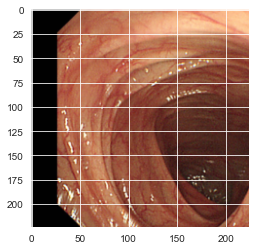

In [9]:
single_batch = next(iter(train_loader))
single_batch[0].shape
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape
plt.imshow(single_image.permute(1, 2, 0))

In [10]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [11]:
model = resnet18
model.to(device)
#print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [12]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [13]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
print("Begin training.")
for e in tqdm(range(1, 101)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 4.37159 | Val Loss: 0.00066 | Train Acc: 63.828| Val Acc: 100.000
Epoch 02: | Train Loss: 4.26219 | Val Loss: 0.06115 | Train Acc: 34.103| Val Acc: 100.000
Epoch 03: | Train Loss: 1.86426 | Val Loss: 0.00422 | Train Acc: 54.000| Val Acc: 100.000
Epoch 04: | Train Loss: 2.78170 | Val Loss: 0.13484 | Train Acc: 21.966| Val Acc: 100.000
Epoch 05: | Train Loss: 2.00712 | Val Loss: 0.10793 | Train Acc: 24.138| Val Acc: 100.000
Epoch 06: | Train Loss: 1.68592 | Val Loss: 0.09003 | Train Acc: 24.586| Val Acc: 100.000
Epoch 07: | Train Loss: 1.68194 | Val Loss: 0.16639 | Train Acc: 18.931| Val Acc: 100.000
Epoch 08: | Train Loss: 1.44516 | Val Loss: 0.25855 | Train Acc: 15.483| Val Acc: 100.000
Epoch 09: | Train Loss: 1.21661 | Val Loss: 0.27987 | Train Acc: 18.931| Val Acc: 100.000
Epoch 10: | Train Loss: 1.25430 | Val Loss: 0.16715 | Train Acc: 25.897| Val Acc: 100.000
Epoch 11: | Train Loss: 1.20307 | Val Loss: 0.20559 | Train Acc: 21.103| Val Acc: 100.000
Epoch 12: 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

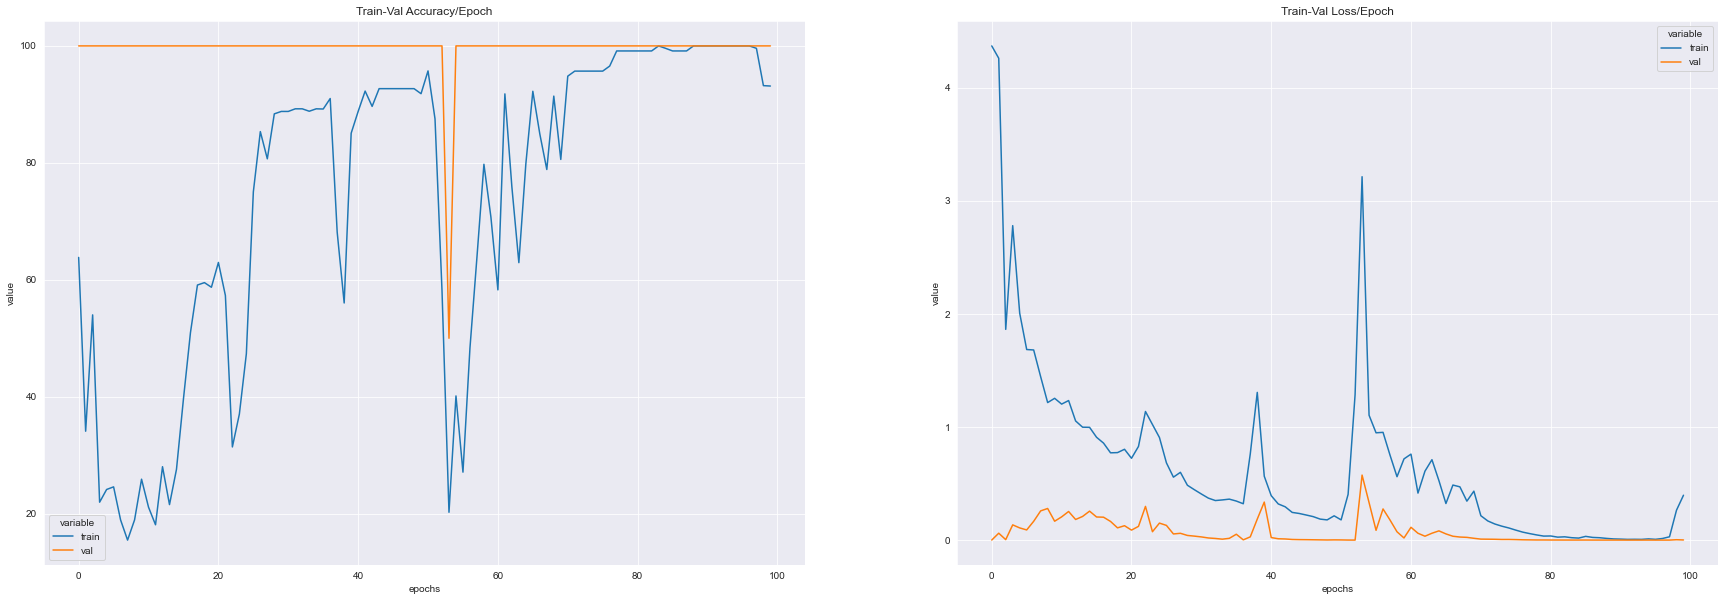

In [15]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [16]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/122 [00:00<?, ?it/s]

In [17]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.67      0.03      0.06        62
           1       0.50      0.98      0.66        60

    accuracy                           0.50       122
   macro avg       0.58      0.51      0.36       122
weighted avg       0.58      0.50      0.36       122



In [18]:
print(confusion_matrix(y_true_list, y_pred_list))

[[ 2 60]
 [ 1 59]]
